In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import wordcloud

In [2]:
def readfile(path):
    f = open(path, 'r')
    c = f.read()
    return c

In [3]:
# normalize a string
def normalize(s, case_folding=True, stopword_removal=True, punctuation_removal=True, newline_removal=True, punctuation_whitelist=[]):

    if not s:
        return None

    # set lowercase
    if case_folding:
        s = s.lower()

    # remove custom html characters and tabs
    s = re.sub(r"&[a-z]{1,3};", " ", s)
    s = s.replace('\t', '')

    # replace punctuation marks with a blank space
    if punctuation_removal:
        for character in list(string.punctuation) + ['”', '“']:
            if character not in punctuation_whitelist:
                s = s.replace(character, ' ')

    # remove newline characters ('\n')
    if newline_removal:
        s = s.replace('\n', ' ')

    # remove stop words given in stopwords.txt from the string
    if stopword_removal:
        b = open('stopwords.txt')
        stop_words = [ line[:-1] for line in b.readlines() ]
        b.close()

        for word in stop_words:
            s = re.sub(r" {} ".format(word), " ", s)
            s = re.sub(r"^{} ".format(word), " ", s)
            s = re.sub(r" {}$".format(word), " ", s)

    # shorten mutliple blank spaces into one
    s = re.sub(r" +", " ", s)

    return s


In [4]:
corpus = readfile('data/twocities.corpus')

In [5]:
corpus = normalize(corpus, stopword_removal=False, punctuation_whitelist=['!', '.', '?', '\''])

corpus = corpus.replace('mrs.', 'mrs')
corpus = corpus.replace('mr.', 'mr')

In [6]:
start      = 'the footsteps die out for'
startindex = corpus.index(start)

sentences  = re.split('\.|\?|\!', corpus[startindex:])

words      = normalize(corpus, stopword_removal=False)[startindex:].split(' ')
words      = [ word for word in words if re.match('[a-z]+', word) ]

In [7]:
unique_words, counts_words = np.unique(words, return_counts=True)

In [8]:
frequencies_dict = {}
for word, count in zip(unique_words, counts_words):
    frequencies_dict[word] = count

In [9]:
frequencies = []
for word, count in zip(unique_words, counts_words):
    frequencies.append([word, count])

In [10]:
frequencies.sort(key = lambda x: -x[1]) 

In [11]:
frequencies = np.array(frequencies)

In [12]:
freqs_cumulative = [0]
for freq in frequencies[:,1].astype(int):
    freqs_cumulative.append(freqs_cumulative[-1] + freq)
    
wcount = freqs_cumulative[-1]

freqs_cumulative = np.array(freqs_cumulative[1:])/wcount

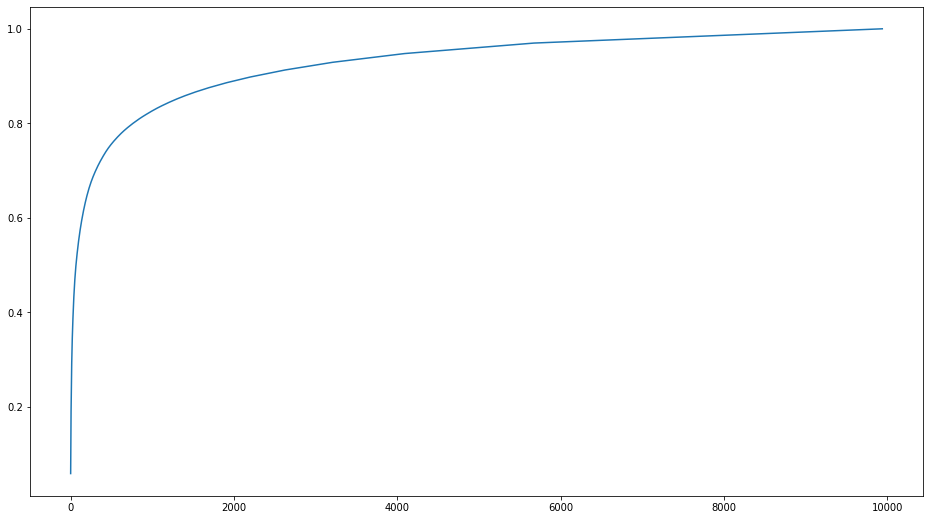

In [13]:
fig, axs = plt.subplots(1,1, figsize=(16,9))

axs.plot(freqs_cumulative)

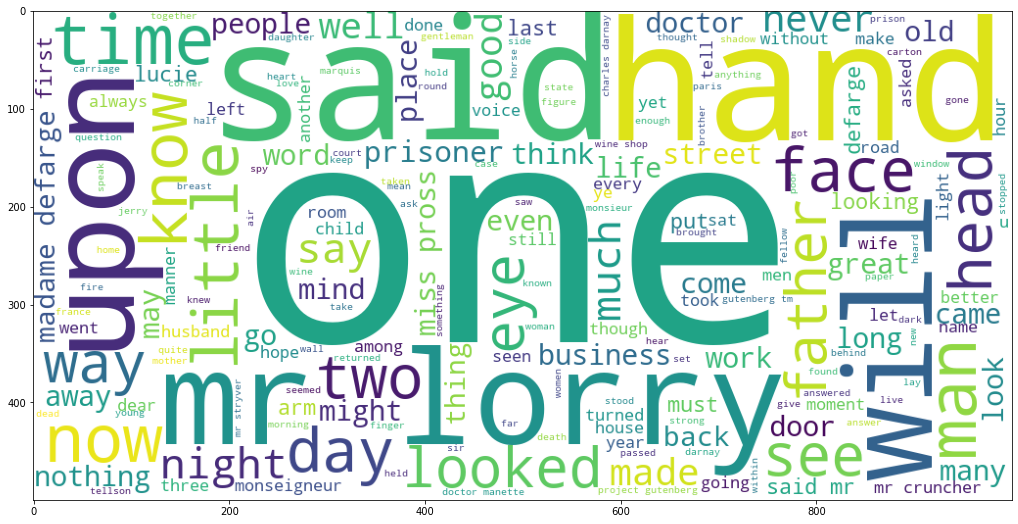

In [14]:
wc = wordcloud.WordCloud(background_color='white', width=1000, height=500)
plt.figure(figsize=(19,9))
plt.imshow(wc.generate(corpus))

In [15]:
def sentences_to_feature(sentences, feature, frequencies):
    all_orders = []
    
    freq_list = list(frequencies[:,0])
    
    if feature == 'orders':
        for sentence in sentences:
            sentence_orders = [ freq_list.index(word) for word in sentence.split(' ') if word in freq_list]
            all_orders.append(sentence_orders)
        
        return all_orders
    
    if feature == 'frequencies':
        freqs = np.array(frequencies[:,1]).astype(float)/wcount
        for sentence in sentences:
            sentence_orders = [ freqs[freq_list.index(word)] for word in sentence.split(' ') if word in freq_list]
            all_orders.append(sentence_orders)
        
        return all_orders

In [16]:
sentence_orders      = sentences_to_feature(list(sentences), 'orders', frequencies)
sentence_frequencies = sentences_to_feature(list(sentences), 'frequencies', frequencies)

sentence_orders[0], sentences[0]

([0, 706, 587, 42, 18, 160, 1170, 0, 164, 785, 3, 121, 8],
 'the footsteps die out for ever book the first recalled to life i')

In [17]:
#deprecated
def get_ideal_index(sentences, frequencies):
    
    xfrequencies = np.copy(frequencies)
    #print('xfreq', xfrequencies[:10])
    
    xwords       = list(xfrequencies[:,0])
    
    #print('xwords', xwords[:10])
    
    xsentences   = [ sentence.split(' ') for sentence in sentences.copy() ]
    #print('sentences', xsentences[:4])
    xsentences   = [ [token for token in sentence if token in xwords] for sentence in xsentences if sentence != [] ]
    xsentences   = [ sentence for sentence in xsentences if sentence != []]
    #print('sentences', xsentences)
    
    for word in xwords:
        for i, sentence in enumerate(xsentences):
            for token in sentence:
                #print('TS:', token, sentence)
                if token == word:
                    sentence.remove(token)
                    
            if sentence == []:
                #print(i)
                return i
    
    return -1
                    
    

In [18]:
#deprecated
def get_ideal_index_max(sentences, frequencies):
    
    xfrequencies = np.copy(frequencies)
    
    xwords       = list(xfrequencies[:,0])

    xsentences = [' '.join(list(set(sentence.split(' ')))) for sentence in sentences ]
    xsentence_frequencies = sentences_to_feature(list(xsentences), 'frequencies', frequencies)

    sums = [ np.sum(xsf) for xsf in xsentence_frequencies ]

    return np.argmax(sums)
    
    

In [19]:
def get_ideal_index_max_avg(sentences, frequencies):
    
    xfrequencies = np.copy(frequencies)
    
    xwords       = list(xfrequencies[:,0])

    xsentences = [' '.join([token for token in list(set(sentence.split(' '))) if token in xwords ]) for sentence in sentences ]
    xsentence_frequencies = sentences_to_feature(list(xsentences), 'frequencies', frequencies)

    sums = [ np.sum(xsf)/len(xsf) if xsf != [] else 0 for xsf in xsentence_frequencies ]

    return np.argmax(sums)
    
    

In [22]:
def get_in_order(sentences, frequencies, sentence_count, metric="vanilla"):
    
    sentences_ordered = []

    remaining_sentences   = [ sentence for sentence in set(sentences.copy()) if len(sentence)>5 ]
    remaining_frequencies = np.copy(frequencies)

    print(len(remaining_sentences), len(remaining_frequencies))
    
    cumulative_return = 0

    vocab = []
    learning_history = [0]

    for i in range(sentence_count):

        if metric == "vanilla":
            chosen_index = 1

        elif metric == "def":
            chosen_index = get_ideal_index(remaining_sentences, remaining_frequencies)

        elif metric == "max":
            chosen_index = get_ideal_index_max(remaining_sentences, remaining_frequencies)

        elif metric == "max-avg":
            chosen_index = get_ideal_index_max_avg(remaining_sentences, remaining_frequencies)
        
        else:
            print("error: invalid metric")
            return None
        
        if chosen_index == -1:
            print("error")
            return None

        sentence = remaining_sentences.pop(chosen_index)

        newvocab = [ word for word in set(sentence.split(' ')) if word not in vocab ]
        filtered = ' '.join(newvocab)

        orders   = sentences_to_feature(list([filtered]), 'orders', remaining_frequencies)
        sfreqs   = sentences_to_feature(list([filtered]), 'frequencies', remaining_frequencies)

        vocab   += newvocab

        new_percentage = 100*np.sum(sfreqs) if sfreqs else 0
        cumulative_return += new_percentage

        trunc = 100
        print('{} - return: {:.2f}% ({:.2f}% cumulative)'.format(i, new_percentage, cumulative_return),
              f'\n{chosen_index}:\t"{sentence[:trunc]}{"..."*int(len(sentence)>trunc)}"', '\n')

        learning_history.append(learning_history[-1] + new_percentage)
        sentences_ordered.append(sentence)

        for order in orders:
            remaining_frequencies = np.delete(remaining_frequencies, order, 0)
            
        if not remaining_sentences:
            break
            
    plt.plot(learning_history)
    
    return sentences_ordered, learning_history

In [ ]:
output = get_in_order(sentences, frequencies, 5, metric="max-avg")

7481 9940
0 - return: 5.81% (5.81% cumulative) 
1441:	" the prisoner's" 

1 - return: 4.65% (10.46% cumulative) 
5046:	" and you" 

2 - return: 4.39% (14.85% cumulative) 
1377:	" of it" 



In [ ]:
def get_cumulative_count(sentences):
    counts = [0]
    vocabs = [set([]), ]
    for sentence in sentences:
        tokens = [ token for token in set(sentence.split(' ')) if token in words ]
        counts.append(len)
        vocabs.append(set(list(vocabs[-1])+tokens))
    return counts, vocabs